In [18]:
from numpy.core.numeric import NaN
from MCtool.RFilter import gray
from genericpath import exists
from matplotlib import image
import math
import sys
import time

import cv2
from matplotlib import pyplot as plt
from tensorflow.python.keras.backend import dtype
from DeepLearning import LearnAndTest
from Rpkg.Rfund.InputFeature import InputFeature
import datetime
import os
import gc
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

import Filtering

import torch
from torch import nn


import DeepLearning
from tensorflow.keras.optimizers import Adam

from Rpkg.Rfund.InputFeature import InputFeature
from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

from MCtool import RFilter, resultEval
from DeepLearning import save_eval_result

import numpy as np
import cv2
import torch
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

#early stopping なし
from unet import UNet
from trainer import Trainer




In [19]:
# Make sure there is no randomness in the output so that the output is reproduceable
import torch
import numpy as np
import random

# Set seed for Python random module
random.seed(42)

# Set seed for NumPy
np.random.seed(42)

# Set seed for PyTorch
torch.manual_seed(42)

# If you are using GPU
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Make the convolution operations deterministic
torch.backends.cudnn.deterministic = True

# Disable the CUDNN benchmark to ensure deterministic results
torch.backends.cudnn.benchmark = False


In [20]:
N_BLOCK = 4
LR = 0.01
OUTPUT_DIR = 2

# after the 4 divided conv1x1 108/4 = 27
IN_CHANNEL = 45

# AUGMENTATION  =  10


# def random_test_choose(test_data):
#     for i in range(len(test_data)):
#         test_data[i] +=  '-' + str(random.randint(1, AUGMENTATION)) + '.'
#     return test_data



# INPUT = ['N1', 'N2']
# VALIDATION = [ 'N3']


INPUT = ['N1', 'N2']
VALIDATION = [ 'N3']
ANNEALING = []

# on data aug
#TEST = ['oN4']

# on original dataset
TEST = ['oN4']

# Randomly chooses one image from the test augmented image to ensure uniqueness and integrity of the test dataset
# For example if the augmentaion scale is 10x, it means there are 10 aug images from single original image
# Since we cant include all the image to the testing because the original one image is used 10 times
# So random one image is chosen from the aug 10x imgs
#TEST = ['N4-1', 'N4-2', 'N4-3', 'N4-4', 'N4-5', 'N4-6', 'N4-7', 'N4-8', 'N4-9']
#TEST = random_test_choose(TEST)




print('Test dataset:')
print(TEST)

Test dataset:
['oN4']


In [21]:
# 自分の環境設定がうまくいったかどうかを確認しましょう、特にGPUの動作
# Prints the version of PyTorch installed
print('PyTorch Version installed: ' + torch.__version__)

# Prints the version of CUDA associated with the installed PyTorch version
print('CUDA version associated with PyTorch version: ' + torch.version.cuda)

# Prints the version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch
print('Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch' + str(torch.backends.cudnn.version()))

# Same as the line above
print('CUDA is available: ' + str(torch.cuda.is_available()))

# Returns the number of available CUDA-enabled GPUs
print('Number of GPUs compatible with CUDA:' + str(torch.cuda.device_count()))

# Returns the name of the GPU at index 0
print('Name of the GPU at index 0: '  + str(torch.cuda.get_device_name(0)))

# Returns the index of the current CUDA device being used
print('Current CUDA device index: '  + str(torch.cuda.current_device()))


PyTorch Version installed: 2.3.0+cu121
CUDA version associated with PyTorch version: 12.1
Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch8902
CUDA is available: True
Number of GPUs compatible with CUDA:1
Name of the GPU at index 0: NVIDIA GeForce RTX 2080 Ti
Current CUDA device index: 0


In [22]:
# ファイル名の先頭部分（prefix）により自動的にファイル名を抽出するアルゴリズム。
# 実際それぞれのファイル名は違うと思うので、必須ではない

""" 

Extracts filenames in directory if they start with the prefix input 


Args/Parameters:

    directory_path (string): The path of the dir (ex: /root/home/Documents/etc)
    
    prefix (string): Prefix of the file name (ex: 'Bo' is a prefix of 'Bone')

Returns:

    sorted_file_names (list of str): File names sorted in ascending order in the dir without extension ex: ['bone1', 'bone2', ...]

Raises:

    SomeError: ...

"""

def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names


In [23]:
# #############################
# ###bugged/ doesnt read by order
# ###Custom Function renames all files in format N1-...
# ###Only need to run it one time
# #############################

# import os
# from PIL import Image

# def rename_images(directory):
#     # Get a list of all files in the directory
#     files = os.listdir(directory)
    
#     # Filter out only the image files
#     image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
#     # Sort the image files to ensure consistent naming
#     image_files.sort()
    
#     # Initialize counter
#     counter = 1
    
#     # Iterate through the image files
#     for filename in image_files:
#         # Open the image
#         image_path = os.path.join(directory, filename)
#         with Image.open(image_path) as img:
#             # Rename the image file
#             new_filename = f"N1-{counter}" + os.path.splitext(filename)[1]
#             new_image_path = os.path.join(directory, new_filename)
            
#             # Save the image with the new name
#             img.save(new_image_path)
        
#         # Increment the counter
#         counter += 1

# # Specify the directory containing the images
# directory_path = "/home/eric/Downloads/imgNaming/processing"

# # Call the function to rename the images
# rename_images(directory_path)


In [24]:
import pathlib
from pathlib import Path

# ここで、folder名とかPathとか色々設定

# Setting the directory name, path and other settings

# Define the root directory where your project is located
# Defining a Path object for the project's root dir
root_dir = Path(pathlib.Path.cwd())

# result folder name
date_str = '20241017-Conv1x1-' + str(OUTPUT_DIR)

# Define the directories for different types of data
# Concatenating the root dir to the different dataset dirs
data_dir = str(root_dir / "img_1006t/originalTest")
feature_dir = str(root_dir / "img_1006t/testFeature") 
labeled_dir = str(root_dir / "img_1006t/testLabel")

# test_data_dir = str(root_dir / "img_1006/originalTest") 
# test_labeled_dir = str(root_dir / "img_1006/testLabel") 
# test_feature_dir = str(root_dir / "img_1006/testFeature")


# annealing_img_dir = str(root_dir / "img_1006/annealing_img") # 焼きなまし法時に使う
# annealing later, original for now
annealing_img_dir = str(root_dir / "img_1006/original")
result_dir = str(root_dir / "result" / date_str)
test_result_dir= str(root_dir / "result_test" / date_str)

# Making directories based on the path string result_dir and test_result_dir
Path(result_dir).mkdir(parents=True, exist_ok=True)
Path(test_result_dir).mkdir(parents=True, exist_ok=True)

# Prints the paths of the dirs
print('Root directory: ' + str(root_dir))
print('Data directory (original dir): ' + str(data_dir))
print('Feature img directory: ' + str(feature_dir))
print('Labeled img directory: ' + str(labeled_dir))
print('Annealing directory: ' + str(annealing_img_dir))
print('Result directory: ' + str(result_dir))
print('Test result directory: ' + str(test_result_dir))

# Defining variables filename list of path str starts with the prefix format
# In this case: N1 and N3 is training data and N2 is validation data and N4 is a test data
input_train = []
input_name_val = []
annealing_input_name = []
input_train = []
test_input_name = []
for raw_input_img in INPUT:
    input_train.extend(file_names_with_prefix(data_dir, raw_input_img))
for raw_val_img in VALIDATION:
    input_name_val.extend(file_names_with_prefix(data_dir, raw_val_img))
for raw_anneal in ANNEALING:
    annealing_input_name.extend(file_names_with_prefix(data_dir, raw_anneal))
for raw_test in TEST:
    test_input_name.extend(file_names_with_prefix(data_dir, raw_test))


####old version of assigning
# input_train = file_names_with_prefix(data_dir, INPUT)
# input_name_val = file_names_with_prefix(data_dir, VALIDATION)
# annealing_input_name = file_names_with_prefix(data_dir, ANNEALING)
# test_input_name = file_names_with_prefix(data_dir, TEST) 




# added this part to investigate the overfitting comment out when it is done
#test_input_name = input_train
#test_input_name = input_name_val


# extra_dataset = file_names_with_prefix(data_dir,'N5-')
# input_train.extend(extra_dataset)

# Prints the each data image name
print(input_train)
print(input_name_val)
print(annealing_input_name)
print(test_input_name)
# print(extra_dataset)


# Defining a var to store each list length
len_train = len(input_train)
len_val = len(input_name_val)
len_test = len(test_input_name)
len_annealing = len(annealing_input_name)


print(len(input_train))

print(len(input_name_val))
print(len(test_input_name))
print(len(annealing_input_name))


Root directory: /home/eric/Documents/cervicalResearchIIP
Data directory (original dir): /home/eric/Documents/cervicalResearchIIP/img_1006t/originalTest
Feature img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/testFeature
Labeled img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel
Annealing directory: /home/eric/Documents/cervicalResearchIIP/img_1006/original
Result directory: /home/eric/Documents/cervicalResearchIIP/result/20241017-Conv1x1-2
Test result directory: /home/eric/Documents/cervicalResearchIIP/result_test/20241017-Conv1x1-2
['N1-1-2', 'N1-1-15', 'N1-1-18', 'N1-1-10', 'N1-1-27', 'N1-1-6', 'N1-1-28', 'N1-1-14', 'N1-1-7', 'N1-1-11', 'N1-1-5', 'N1-1-22', 'N1-1-17', 'N1-1-21', 'N1-1-8', 'N1-1-24', 'N1-1-26', 'N1-1-23', 'N1-1-12', 'N1-1-30', 'N1-1-4', 'N1-1-25', 'N1-1-3', 'N1-1-16', 'N1-1-20', 'N1-1-9', 'N1-1-1', 'N1-1-29', 'N1-1-13', 'N1-1-19', 'N1-2-4', 'N1-2-6', 'N1-2-21', 'N1-2-7', 'N1-2-17', 'N1-2-8', 'N1-2-18', 'N1-2-10', 'N1-2-30', '

In [25]:
# 特徴画像の特徴一覧をリストとして取得
inputfeature_list = list(map(str, InputFeature))
print(inputfeature_list)

feature_num = len(inputfeature_list)
print(feature_num)

['GRY_', 'NML1', 'NML2', 'NML3', 'TOP1', 'TOP2', 'TOP3', 'TOP4', 'SBLX', 'SBLY', 'SBLM', 'SBLD', 'SBL1', 'SBL2', 'SBL3', 'SBL4', 'LPL1', 'LPL2', 'MEA1', 'MEA2', 'GAU1', 'GAU2', 'MED1', 'MED2', 'LBP1', 'LBP2', 'LBP3', 'ETC1', 'ETC2', 'STC1', 'STC2', 'HGF_', 'NGP_', 'POS1', 'POS2', 'POS3', 'SOL_', 'EMB1', 'EMB2', 'EMB3', 'KNN1', 'KNN2', 'BLT1', 'BLT2', 'OOO_']
45


In [26]:
## 重み計算なし
def CreateWeightImage(input_number):
    print("in create now")
    label_dataset = []
    arrDataset = []
    for i in input_number:
        label_path = os.path.join(labeled_dir, f"{i}.png")
        input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        # commented the binary label because the project has more labels than 2 
        #_, binary_label = cv2.threshold(input_originallabel, 0, 255, cv2.THRESH_BINARY)
        
        ## This part was used for decreasing and increasing the label count when there was inconsistency with the label dataset
        
        # if len(np.unique(input_originallabel)) > 11:
        #     print("Defected image detected (more labels):" + f"{i}.png")
        #     print(np.unique(input_originallabel))
        #     for y in range(256):
        #         for x in range (256):
        #             if (input_originallabel[y][x] == 11) or (input_originallabel[y][x] == 12):
        #                 input_originallabel[y][x] = 0
        #     print(np.unique(input_originallabel))
        #     cv2.imwrite('testtttt.png', input_originallabel)
        # elif len(np.unique(input_originallabel)) < 11:
        #     print("Defected image detected (Less labels):" + f"{i}.png")
        #     defected = f"{i}_.png"
        #     print(np.unique(input_originallabel))
        #     path_to_mask = '/home/eric/Desktop/edit8label'

        #     # 25->9 32->10
        #     path_mask_abs = os.path.join(path_to_mask, defected)
        #     mask = cv2.imread(path_mask_abs, cv2.IMREAD_GRAYSCALE)
        #     for y in range(256):
        #         for x in range (256):
        #             if (input_originallabel[y][x] == 0) and (mask[y][x] == 25):
        #                 input_originallabel[y][x] = 9
        #             elif (input_originallabel[y][x] == 0) and (mask[y][x] == 32):
        #                 input_originallabel[y][x] = 10
        #     print(np.unique(input_originallabel))
        #     label_fixed_path = os.path.join(path_to_mask, f"{i}_fixed.png")
        #     cv2.imwrite(label_fixed_path, input_originallabel)
                    
        label_dataset.append(input_originallabel)

    print("Number of label images:", len(label_dataset))

    for i in input_number:
        # changed this part from 100 to 256
        dataset_img = np.zeros((256, 256, feature_num), dtype=np.float32)

        for m in range(feature_num):
            feature_img_path = os.path.join(feature_dir, str(i), f"{inputfeature_list[m]}.png")
            input_featureimg = cv2.imread(feature_img_path, cv2.IMREAD_GRAYSCALE)
            dataset_img[:, :, m] = input_featureimg
        # after the loop the dataset_img size will be like: (256, 256, 108) and the tensor type is np array
        
        
        
        ##this part is dividing the dataset to use multiple conv1x1 operation
        #split_dataset_img = np.array_split(dataset_img, 4, axis = 2)
        #post_conv = np.zeros((256, 256, 4), dtype=np.float32)
        #concat_list = []
        #for index, part in enumerate(split_dataset_img):
            # after this operation shape will be from (256, 256, 27) to (1, 256, 256, 27)
            #part = torch.tensor(part, dtype = torch.float32).unsqueeze(0)
            # changed the shape for the conv again now it is (1, 27, 256, 256) (batch_size, channels, height, width)
            #part = part.permute(0, 3, 1, 2)
            #fusion = nn.Conv2d(in_channels = 27, out_channels = 1, kernel_size = 1, padding = 'same')
            #output_conv = fusion(part)
            #output_conv = output_conv.squeeze(0) #.permute(1, 2, 0) # now it is (256, 256, 1)
            #output_conv = output_conv.cpu().detach().numpy()
            #post_conv[:, :, index] = output_conv[0]
            #print((output_conv).shape)
            #concat_list.append(output_conv)
            
        #concat_output = torch.cat((concat_list[0], concat_list[1], concat_list[2], concat_list[3]), dim = 2)
        ## convert the concat result tensor into numpy array and it has to be on cpu to do the operation
        #print(np.unique(output_conv.detach()))
        #concat_output = concat_output.detach()
        #concat_output = concat_output.numpy()
        
        
        #arrDataset = concat_list
        arrDataset.append(dataset_img)

    arrDataset = np.array(arrDataset)
    print("dataset shape ", arrDataset.shape)
    print("label shape ", np.shape(label_dataset))
    print("end create now")

    return arrDataset, label_dataset


In [27]:
# # ## Test code

# input_dataset,label_dataset = CreateWeightImage(input_train)
# input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val)



In [28]:
# #Augmentation function
# # need to configure further to make it receive the new shape of the label images

# import imgaug.augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapsOnImage

# test_data_dir = str(root_dir / "img_1006/originalTest") 
# test_labeled_dir = str(root_dir / "img_1006/testLabel") 
# test_feature_dir = str(root_dir / "img_1006/testFeature")


# ## 重み計算なし
# def ImageAug(input_number):
#     print("in aug now")
#     label_dataset = []
#     arrDataset = []
#     for i in input_number:
#         label_path = os.path.join(labeled_dir, f"{i}.png")
#         input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
#         label_dataset.append(input_originallabel)


#     print("Number of label images:", len(label_dataset))
    
#     #means x augment
#     augmentation_scale = AUGMENTATION
    
#     seq = iaa.Sequential([
#     #iaa.Fliplr(0.5),  # horizontal flip with 50% probability
#     #iaa.Flipud(0.5),  # vertical flip with 50% probability
#     iaa.Affine(
#         rotate=(-20, 20),  # rotate by -20 to +20 degrees
#         scale=(0.8, 1.2),  # scale by 80% to 120%
#         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}  # translate by -20% to +20%
#     ),
#     #iaa.ElasticTransformation(alpha=50, sigma=5),  # elastic deformation
#     #iaa.Multiply((0.8, 1.2)),  # change brightness
#     #iaa.LinearContrast((0.75, 1.5))  # change contrast
# ])

    
#     arr_labelDataset = []
#     for i in input_number:
#         print(i)
#         original_img_path = os.path.join(data_dir, str(i) + ".png")
#         input_original_img = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
#         for k in range(augmentation_scale):
#             augmented = seq(image = input_original_img, segmentation_maps = SegmentationMapsOnImage(label_dataset[input_number.index(i)], shape = label_dataset[input_number.index(i)].shape))
#             arrDataset.append(np.array(augmented[0]))
#             arr_labelDataset.append(np.array(augmented[1].get_arr()))
            
#         #arrDataset = np.array(arrDataset)
#         #arr_labelDataset = np.array(arr_labelDataset)
#         for c, aug_data, aug_label in zip(range(1,augmentation_scale + 1), arrDataset, arr_labelDataset):
#             path1 = os.path.join(test_data_dir, (i + '-' + str(c)+'.png'))
#             path2 = os.path.join(test_labeled_dir, (i + '-' + str(c)+'.png'))
#             #print(path1)
#             cv2.imwrite(path1, aug_data)
#             cv2.imwrite(path2, aug_label)
        
#         arrDataset.clear()
#         arr_labelDataset.clear()
# print(file_names_with_prefix(data_dir, ''))
# ImageAug(file_names_with_prefix(data_dir, ''))


In [29]:
# # 重みを基づいて、MC画像を生成する
# def CreateWeightImageforShow(weight, input_number, index):
#     sum_weight = sum(weight)  # Calculate total weight

#     label_dataset = []
#     input_dataset = []
#     dataset_original = []

#     # Read label images
#     for i in input_number:
#         input_originallabel = cv2.imread(labeled_dir + "/" + str(i) + ".png", flags=0)
#         label_dataset.append(input_originallabel)

#     print('Weight image for show, label length = ', len(label_dataset))

#     # Create output directory
#     os.makedirs(test_result_dir + "/weightImage/" + str(index), exist_ok=True)

#     # Generate weighted images
#     for i in input_number:
#         # Create a blank image to store the weighted image, using float type for accumulation
#         dataset_img = np.zeros((256, 256, 3), dtype=np.float32)
#         input_originalimg = cv2.imread(data_dir + "/" + str(i) + ".png")

#         dataset_original.append(input_originalimg)
#         for m in range(feature_num):
#             input_featureimg = cv2.imread(feature_dir + "/" + str(i) + "/" + inputfeature_list[m] + ".png", cv2.IMREAD_GRAYSCALE)
#             # Normalize the feature image
#             normalized_feature_img = cv2.normalize(input_featureimg.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
#             # Accumulate the weighted feature image
#             dataset_img += normalized_feature_img[:, :, None] * (weight[m] / sum_weight)  # Convert 2D array to 3D array

#         # Normalize the accumulated image to the range 0-255
#         dataset_img = cv2.normalize(dataset_img, None, 0, 255, cv2.NORM_MINMAX)
#         output_img = dataset_img.astype(np.uint8)  # Convert to uint8

#         input_dataset.append(output_img)
#         # Write to file
#         cv2.imwrite(f"{test_result_dir}/weightImage/{index}/{i}.png", output_img)

#     return input_dataset, label_dataset


In [30]:
# #############################
# ##Custom Function generates feature img
# #############################

# import os
# import numpy as np
# from PIL import Image

# def read_images_from_directory(dir_path):
#     IMAGE_SIZE = 256


#     """
#     Reads all image files from a directory and returns a list of images as NumPy arrays.
    
#     :param dir_path: Path to the directory containing the images.
#     :param image_size: Size of the images (assumes square images).
    
#     :return: img_list: List of images as NumPy arrays.
#     """
#     img_list = []
#     fn_without_list = []

    
#     # Iterate through all files in the directory
#     for filename in os.listdir(dir_path):
#         # Check if the file is an image file (you can add more extensions if needed)
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             # Construct the full path to the image
#             img_path = os.path.join(dir_path, filename)
            
#             # Open the image and resize it to the desired size
#             img = Image.open(img_path).convert('L')
#             img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            
#             # Convert the image to a NumPy array 
#             img_array = np.asarray(img, dtype=np.float64)
            
#             # Append the image array to the list
#             img_list.append(img_array)
#             # Gets the file name without extension for creating dir 
#             filename_without_extension = os.path.splitext(filename)[0]
#             fn_without_list.append(filename_without_extension)
    
#     return img_list, fn_without_list

# img_list, fn_without_list = read_images_from_directory(data_dir)
# print(len(fn_without_list))
# #print(fn_without_list[0])

# counter = 0
# for fn_wthout, img in zip(fn_without_list, img_list):
#     #print("File that is being processed at the moment: " + str(fn_wthout))
#     WriteFile.make_folder(feature_dir, '/' + fn_wthout)
#     fn_feature_list = []
#     filtered_img_list = []
#     for feature in InputFeature:
#         #print('Processed feature now:' + str(feature))
#         filtered_img= Filtering.single_image(img, feature)
#         filtered_img_list.append(filtered_img)
#         fn_feature_list.append(str(feature) + '.png')
#     WriteFile.save_images(os.path.join(feature_dir,fn_wthout), fn_feature_list, filtered_img_list)
#     counter += 1 
#     print(counter)


In [31]:
def print_model_shapes(model, input_tensor):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        print("-----------------------")

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    print("Model Architecture:")
    print(model)

    # Pass a dummy input tensor through the model to trigger the forward hooks
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()


In [32]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # Change from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # Linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # Typecasting to float32
    #print("in pre")
    #print(np.unique(img))
    return img

# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim = 1)  # Perform argmax to generate 1 channel
    #img = img * 255.0 commented as the labels are from 0 to 11 in my case
    img = img.cpu().numpy().astype(np.uint8)  # Send to CPU and transform to numpy.ndarray
    # If batch_size > 1, you may need to loop through each batch and save them separately
    # If batch_size == 1, you can remove the batch dimension to save a single image

    # used for checking the unique label values whether if it is 0 to 11 or 0 to 255 scale
    #print("in post")
    #print(np.unique(img))


    img = np.squeeze(img)  # Remove batch dim and channel dim -> [H, W]
    # img = re_normalize(img)  # Scale it to the range [0-255]

    # If your image has multiple channels (C>1), like an RGB image, before saving with cv2.imwrite
    # you need to ensure the channel order is [B, G, R] instead of the common [R, G, B]
    # If C == 1, you can further reduce dimensions -> [H, W]
    if img.shape[0] == 3:  # [C, H, W]
        img = np.transpose(img, (1, 2, 0))  # [H, W, C]
        img = img[:, :, ::-1]  # Convert RGB to BGR
    elif img.shape[0] == 1:  # [C, H, W]
        img = np.squeeze(img, 0)  # [H, W]
    return img


In [33]:
# earlystoppingあり
# numpy形式のまま入力する用改良
# 学習を行い予測結果画像を出力するとこまで
from customdatasets import SegmentationDataSet0
from customdatasets import SegmentationDataSet1
from torch.utils.data import DataLoader

def Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val,type_number):
    # 引数を追加して保存先を指定するよう改良
    # try_number:何回目の焼きなましかどうか。モデルの保存に使用

    # dataset training
    dataset_train2 = SegmentationDataSet0(
                                        #inputs=dataset_original,
                                        inputs=input_dataset,
                                        targets=label_dataset,
                                        transform=transforms_training)

    # dataloader training
    dataloader_training2 = DataLoader(dataset=dataset_train2,
                                     batch_size = 16,
                                     shuffle=True)
    #もとはシャッフルtrue


    batch = next(iter(dataloader_training2))
  
    x, y = batch
    print("x.shape = ", x.shape)
    print("x.min(), x.max() = ", x.min(), x.max())
    print("y.shape = ", y.shape)
    print("torch.unique(y) = ", torch.unique(y))


    
    # dataset training
    dataset_val = SegmentationDataSet0(inputs=input_dataset_val,
                                        targets=label_dataset_val,
                                        transform=transforms_val)
    #書き換え箇所
    dataloader_val = DataLoader(dataset=dataset_val,
                                     batch_size = 16,
                                     shuffle=False)
    
    
    
    ###earlystopping あり

    from unet import UNet
    from trainer2 import Trainer2 
    from torch import nn #import torch 
    from pytorchtools import EarlyStopping
    from torch.nn import BCEWithLogitsLoss

    #device
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else: 
        torch.device('cpu')
        print("Before creating the UNet model: GPU was not available and CPU will be used instead")

    # custom logging the parameters of the UNet
    inChannels = IN_CHANNEL
    outChannels = 11
    nBlocks = N_BLOCK
    startFilters = 32

    from customLog import custom_logger
    
    #custom_logger("/log/customLog.log", inChannels, outChannels, nBlocks, startFilters)

    #model
    model = UNet(in_channels = inChannels,
                 out_channels = outChannels,
                 n_blocks = nBlocks, 
                 start_filters=startFilters,
                 activation='relu',
                 normalization='batch',
                 conv_mode='same',
                 dim=2,
                 ).to(device)

    ### Later for experimenting
    #from originalUNet import Original_UNet
    #model = Original_UNet()

    # Assuming input_tensor is a sample input tensor with the correct shape (e.g., torch.randn(1, 3, 100, 100))
    input_tensor = torch.randn(1, 45, 100, 100).to(device)  # Adjust the shape as needed
    # print_model_shapes(model, input_tensor)


    #criterion
    criterion = torch.nn.CrossEntropyLoss()
    # criterion = BCEWithLogitsLoss()

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #trainer
    trainer = Trainer2(model=model, 
                       device=device, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       training_DataLoader=dataloader_training2,
                       #validation_DataLoader=None, 
                       validation_DataLoader=dataloader_val, 
                       lr_scheduler=None, 
                       epochs=200, ##😺😺😺😺 epoch=0, 
                       notebook=True)
  
    print("=======start training======")
    # start training
    training_losses, validation_losses, lr_rates = trainer.run_trainer()
    print("***************************")

    
    
    #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    model_dir = os.path.join("model", date_str)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = f"model.pt"
    model_path = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"modelname:{model_name}を保存しました")

    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    

    # images = annealing_input_dataset
    images = input_dataset_val

    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict the segmentation maps 
    output = [predict(img, model, preprocess, postprocess, device) for img in images]


    for i in range(len(input_name_val)):
        if(type_number == 0):
            cv2.imwrite(os.path.join(result_dir, f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 1):
            cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 2):
            cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])



In [34]:
## Test Learn_EA without annealing
# training transformations and augmentations
transforms_training = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

#追加箇所ver3
transforms_val =  ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])
# random seed
random_seed = 0
input_dataset,label_dataset = CreateWeightImage(input_train)
input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val)


Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val,0)

in create now
Number of label images: 600
dataset shape  (600, 256, 256, 45)
label shape  (600, 256, 256)
end create now
in create now
Number of label images: 300
dataset shape  (300, 256, 256, 45)
label shape  (300, 256, 256)
end create now
x.shape =  torch.Size([16, 45, 256, 256])
x.min(), x.max() =  tensor(0.) tensor(1.)
y.shape =  torch.Size([16, 256, 256])
torch.unique(y) =  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
in constructor inchannel: 45
Input channel count5
=======start training======


Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/38 [00:00<?, ?it/s]

/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 2.0114739694093404
Validation loss decreased (inf --> 2.011474).  Saving model ...


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.31066097397553294
Validation loss decreased (2.011474 --> 0.310661).  Saving model ...


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3918753360447131
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.33412238877070577
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3670702647221716
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.33053144812583923
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3507679202838948
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.295594807518156
Validation loss decreased (0.310661 --> 0.295595).  Saving model ...


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.38568929151484843
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.24298472898571113
Validation loss decreased (0.295595 --> 0.242985).  Saving model ...


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.2654877050142539
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.23253781583748365
Validation loss decreased (0.242985 --> 0.232538).  Saving model ...


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.25542060246593074
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.25625540865095037
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.2905023525419988
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.2516368662840442
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.26474134251475334
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.26696361522925527
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.2742775266892032
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.28140689511048167
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.2921156416598119
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.26775082122338445
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.33924977893107816
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.26734903415566996
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3073892475743043
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.28900919580145884
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.30942814522667933
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.31626438486732933
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3008457783021425
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3053361565658921
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.35382510917751414
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.30750987914047745
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3099948101137814
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.31159601948763194
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.32509854082998474
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3259963385368648
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3310189027535288
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.34663885635764974
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.32347398016013595
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.33356923609972
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.34045018294924184
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3407158667319699
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3372780661049642
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.378087722549313
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.32608832693413686
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3302961834951451
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.34372772786178085
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3388248164402811
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.32302582107092204
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3741787134816772
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.34699274011348424
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3542954953093278
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.34105410073932846
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.35343580536152186
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.35880980993572037
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3487366896710898
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.359231009687248
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3571931551161565
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.34567607782388987
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.39443792598812205
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.35134818483340113
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

val_losses 0.3848770315709867
EarlyStopping counter: 50 out of 50
early stopping epoch: 61
***************************
modelname:model.ptを保存しました


In [35]:
# # Dicecの計算
# def cal_Dice(dir, input_name):
#     # change the label count as your preference
#     Dice = [0] * 2
#     Count1 = [0] * 2 #予測結果の各ラベルの要素数
#     Count2 = [0] * 2 #ラベル画像の
#     Count3 = [0] * 2 #正解した画素数
#     unique_label = set()
#     for index in range(len(input_name)):
#         print('index = ', index)

#         img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
#         img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
#         #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
#         print("予測画像:", dir  + '/' + input_name[index] + ".png")
#         print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        
#         # change the image array size to your need
#         for n in range(255):
#             for l in range(255):
#                 value = img1[n,l]
#                 unique_label.add(value)
#                 if value == 0:
#                     Count1[0] += 1
#                 else:
#                     Count1[1] = Count1[1] + 1
#                 # Count1[value] = Count1[value] + 1
#                 value2 = img2[n,l]
#                 if value2 == 0:
#                     Count2[0] = Count2[0] + 1
#                 else:
#                     Count2[1] = Count2[1] + 1
#                 # Count2[value2] = Count2[value2] + 1

#                 if(img1[n][l] == img2[n][l]):
#                     if value == 0:
#                         Count3[0] = Count3[0] + 1
#                     else:
#                         Count3[1] = Count3[1] + 1
#                     # Count3[value] = Count3[value] + 1


#     for i in range(2):
#         if(Count1[i]+Count2[i] != 0):
#             Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
#     print('Count1 = ', Count1)
#     print('Count2 = ', Count2)
#     print('Count3 = ', Count3)
#     print('Dice = ', Dice)
#     #print(unique_label)

#     return Dice


In [36]:
import statistics
# Dicecの計算
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice


In [37]:
## Test of 1x1conv
import statistics
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    print("Using CPU instead of GPU")
    torch.device('cpu')

model = UNet(in_channels=IN_CHANNEL,  # check the parameters
             out_channels=11,
             n_blocks=N_BLOCK,
             start_filters=32,
             activation='relu',
             normalization='batch', #use instance when "batch" size is greater than 10? batch
             conv_mode='same',
             dim=2).to(device)

model_dir = os.path.join("model", date_str)
print("model_dir = ", model_dir)
model_path = os.path.join(model_dir, "model.pt") # load the model
model_weights = torch.load(model_path)
model.load_state_dict(model_weights)

model.eval()

# create test dataset
test_input_dataset, _ = CreateWeightImage(test_input_name) 

# convert to torch
test_input_tensor = torch.from_numpy(test_input_dataset).float().to(device)

from inference import predict
from transformations import normalize_01, re_normalize
# predict
output = [predict(img, model, preprocess, postprocess, device) for img in test_input_dataset]


plot_output_img = list()
# save images
for i, output_img in enumerate(output):
    #for checking the unique values of the result label
    labels = np.unique(output_img)

    cv2.imwrite(os.path.join(test_result_dir, f"{test_input_name[i]}.png"), output_img)  # 根据需要调整文件路径和命名

    #print(labels)
    plot_output_img.append(output_img)


Dice = cal_DiceMulitple(test_result_dir, test_input_name)
df = pd.DataFrame(Dice)
df = df.T
df.to_csv(test_result_dir + "/Dice.csv", mode='a', header=False) # Diceの結果をcsvに追加



in constructor inchannel: 45
Input channel count5
model_dir =  model/20241017-Conv1x1-2
in create now
Number of label images: 9
dataset shape  (9, 256, 256, 45)
label shape  (9, 256, 256)
end create now
index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241017-Conv1x1-2/oN4-1.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-1.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241017-Conv1x1-2/oN4-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-2.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241017-Conv1x1-2/oN4-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-3.png
index =  3
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241017-Conv1x1-2/oN4-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/testLabel/oN4-4.png
index =  4
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20241017-Conv1x

In [38]:
#########
### To plot the label images of the test dataset
#########

# input_name = test_input_name
# label_img = []
# for index in range(len(input_name)):
#     imgLabel = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
#     label_img.append(imgLabel)

# plot_output_img = label_img


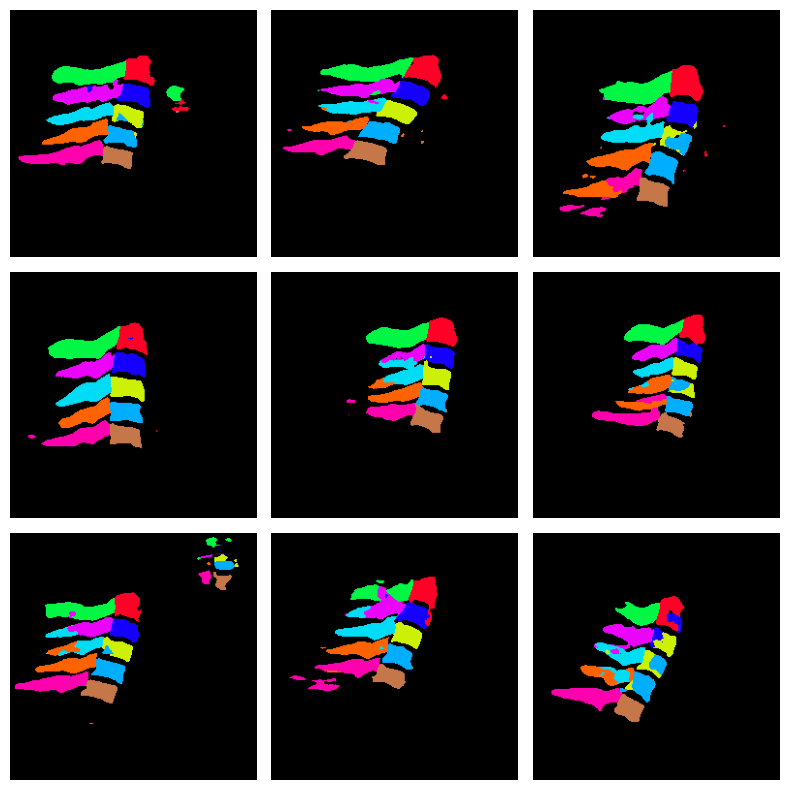

In [39]:
from plotImg import plot_images
plot_img = []
for output_img in plot_output_img:
    labels = np.unique(output_img)
    image = np.ones((255, 255, 3), dtype=np.uint8) * 0
    for x in range(255):
            for y in range(255):
                # Get the pixel value (brightness)
                pixel = output_img[x][y]
               #  print(type(output_img))
                if pixel == labels[0]:
                     image[x, y] = [0,0,0]
                elif pixel == labels[1]:
                     image[x, y] = [2, 247, 68]
                elif pixel == labels[2]:
                     image[x, y] = [255, 0, 38]
                elif pixel == labels[3]:
                     image[x, y] = [234, 5, 250]
                elif pixel == labels[4]:
                     image[x, y] = [21, 0, 255]
                elif pixel == labels[5]:
                     image[x, y] = [0, 220, 245]
                elif pixel == labels[6]:
                     image[x, y] = [205, 240, 7]
                elif pixel == labels[7]:
                     image[x, y] = [255, 98, 0]
                elif pixel == labels[8]:
                     image[x, y] = [0, 174, 255]
                elif pixel == labels[9]:
                     image[x, y] = [255, 0, 174]
                elif pixel == labels[10]:
                     image[x, y] = [198, 119, 74]
                else:
                     print("There are more labels!")
    plot_img.append(image)
plot_images(test_result_dir, plot_img)

In [40]:
import csv
path = test_result_dir
filename = 'featureCombination.csv'
full_path = os.path.join(path, filename)
with open(full_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write a single row containing the string
    writer.writerow([inputfeature_list])
